# Summary

* Name: `dissipation-theory--Study-3.ipynb`
* Author: John A. Marohn
* Date: 2023-09-23
* Continued from: `dissipation-theory--Study-2.ipynb`
* Continued to: `dissipation-theory--Study-4.ipynb`
* Summary: Try to reproduce Figure 7(b) and Figure 9(b) from Lekkala2012.

# Preliminaries

In [1]:
import numpy as np
from dissipationtheory.constants import ureg, epsilon0, qe, kb
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import tqdm
import pandas as pd

In [2]:
THIS = 'dissipation-theory--Study-3'

# Sample and cantilever classes

Use classes to represent the cantilever and the sample so that derived quantities, like the sample's Debye length, can be computed at creation time.

In [3]:
class CantileverModel(object):

    def __init__(self, f_c, V_ts, R, d):

        self.f_c = f_c
        self.V_ts = V_ts
        self.R = R
        self.d = d

        self.omega_c = 2 * np.pi * f_c

    def __repr__(self):

        str = 'cantilever\n\n'
        str = str + '      resonance freq = {:.3f} kHz\n'.format(self.f_c.to('kHz').magnitude)
        str = str + '                     = {:0.3e} rad/s\n'.format(self.omega_c.to('Hz').magnitude)
        str = str + '  tip-sample voltage = {:.1f} V\n'.format(self.V_ts.to('V').magnitude)
        str = str + '              radius = {:.1f} nm\n'.format(self.R.to('nm').magnitude)
        str = str + '              height = {:.1f} nm\n'.format(self.d.to('nm').magnitude)
        
        return str

In [4]:
cantilever = CantileverModel(
    
    f_c = ureg.Quantity(81, 'kHz'),
    V_ts = ureg.Quantity(3, 'V'),
    R = ureg.Quantity(80, 'nm'),
    d = ureg.Quantity(300, 'nm')
)

In [5]:
cantilever

cantilever

      resonance freq = 81.000 kHz
                     = 5.089e+05 rad/s
  tip-sample voltage = 3.0 V
              radius = 80.0 nm
              height = 300.0 nm

In [6]:
class SampleModel1(object):
    
    def __init__(self, cantilever, h_s, epsilon_s, mu, rho, epsilon_d, z_r):

        self.cantilever = cantilever
        self.epsilon_s = epsilon_s
        self.h_s = h_s
        self.mu = mu
        self.rho = rho
        self.epsilon_d = epsilon_d
        self.z_r = z_r

        self.D = ((kb * ureg.Quantity(300., 'K') * self.mu) / qe).to('m^2/s')
        self.LD = (np.sqrt((epsilon0 * kb * ureg.Quantity(300., 'K'))/(self.rho * qe * qe))).to('nm')
        self.Ld = (np.sqrt(self.D / cantilever.omega_c)).to('nm')
        self.epsilon_eff = (self.epsilon_s - complex(0,1) * np.power(self.Ld, 2.) / np.power(self.LD, 2.)).to_base_units()

    def __repr__(self):

        str = cantilever.__repr__()
        str = str + '\nsemiconductor\n\n'
        str = str + '             epsilon (real) = {:0.3f}\n'.format(self.epsilon_s.to('').real.magnitude)
        str = str + '             epsilon (imag) = {:0.3f}\n'.format(self.epsilon_s.to('').imag.magnitude)
        str = str + '                  thickness = {:.1f} nm\n'.format(self.h_s.to('nm').magnitude)
        str = str + '                   mobility = {:0.2e} m^2/(V s)\n'.format(self.mu.to('m^2/(V s)').magnitude)
        str = str + '         diffusion constant = {:0.2e} m^2/s\n'.format(self.D.to('m^2/s').magnitude)
        str = str + '             charge density = {:0.2e} m^{{-3}}\n'.format(self.rho.to('1/m^3').magnitude)
        str = str + '           reference height = {:0.1f} nm\n'.format(self.z_r.to('nm').magnitude)
        str = str + '               Debye length = {:0.1f} nm\n'.format(self.LD.to('nm').magnitude)
        str = str + '           diffusion length = {:0.1f} nm\n'.format(self.Ld.to('nm').magnitude)
        str = str + '   effective epsilon (real) = {:0.3f}\n'.format(self.epsilon_eff.to('').real.magnitude)
        str = str + '   effective epsilon (imag) = {:0.3f}\n\n'.format(self.epsilon_eff.to('').imag.magnitude)
        str = str + 'dielectric\n\n'
        str = str + '  epsilon (real) = {:0.3f}\n'.format(self.epsilon_d.to('').real.magnitude)
        str = str + '  epsilon (imag) = {:0.3f}\n'.format(self.epsilon_d.to('').imag.magnitude)
        str = str + '       thickness = infinite'
        
        return str

In [7]:
sample1 = SampleModel1(

    cantilever = cantilever,
    h_s = ureg.Quantity(1e6, 'nm'),
    epsilon_s = ureg.Quantity(complex(11.9, -0.05), ''),
    mu = ureg.Quantity(1e-5, 'm^2/(V s)'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(11.9, -0.05), ''),
    z_r = ureg.Quantity(100, 'nm')
)

In [8]:
sample1

cantilever

      resonance freq = 81.000 kHz
                     = 5.089e+05 rad/s
  tip-sample voltage = 3.0 V
              radius = 80.0 nm
              height = 300.0 nm

semiconductor

             epsilon (real) = 11.900
             epsilon (imag) = -0.050
                  thickness = 1000000.0 nm
                   mobility = 1.00e-05 m^2/(V s)
         diffusion constant = 2.59e-07 m^2/s
             charge density = 1.00e+21 m^{-3}
           reference height = 100.0 nm
               Debye length = 37.8 nm
           diffusion length = 712.7 nm
   effective epsilon (real) = 11.900
   effective epsilon (imag) = -355.597

dielectric

  epsilon (real) = 11.900
  epsilon (imag) = -0.050
       thickness = infinite

In [9]:
class SampleModel2(object):
    
    def __init__(self, cantilever, epsilon_d, h_d, epsilon_s, mu, rho, z_r):

        self.cantilever = cantilever
        self.epsilon_d = epsilon_d
        self.h_d = h_d
        self.epsilon_s = epsilon_s
        self.mu = mu
        self.rho = rho
        self.z_r = z_r

        self.D = ((kb * ureg.Quantity(300., 'K') * self.mu) / qe).to('m^2/s')
        self.LD = (np.sqrt((epsilon0 * kb * ureg.Quantity(300., 'K'))/(self.rho * qe * qe))).to('nm')
        self.Ld = (np.sqrt(self.D / cantilever.omega_c)).to('nm')
        self.epsilon_eff = (self.epsilon_s - complex(0,1) * np.power(self.Ld, 2.) / np.power(self.LD, 2.)).to_base_units()

    def __repr__(self):

        str = cantilever.__repr__()
        str = str + '\ndielectric\n\n'
        str = str + '  epsilon (real) = {:0.3f}\n'.format(self.epsilon_d.to('').real.magnitude)
        str = str + '  epsilon (imag) = {:0.3f}\n'.format(self.epsilon_d.to('').imag.magnitude)
        str = str + '       thickness = {:.1f} nm\n\n'.format(self.h_d.to('nm').magnitude)
        str = str + 'semiconductor\n\n'
        str = str + '             epsilon (real) = {:0.3f}\n'.format(self.epsilon_s.to('').real.magnitude)
        str = str + '             epsilon (imag) = {:0.3f}\n'.format(self.epsilon_s.to('').imag.magnitude)
        str = str + '                  thickness = infinite\n'
        str = str + '                   mobility = {:0.2e} m^2/(V s)\n'.format(self.mu.to('m^2/(V s)').magnitude)
        str = str + '         diffusion constant = {:0.2e} m^2/s\n'.format(self.D.to('m^2/s').magnitude)
        str = str + '             charge density = {:0.2e} m^{{-3}}\n'.format(self.rho.to('1/m^3').magnitude)
        str = str + '           reference height = {:0.1f} nm\n'.format(self.z_r.to('nm').magnitude)
        str = str + '               Debye length = {:0.1f} nm\n'.format(self.LD.to('nm').magnitude)
        str = str + '           diffusion length = {:0.1f} nm\n'.format(self.Ld.to('nm').magnitude)
        str = str + '   effective epsilon (real) = {:0.3f}\n'.format(self.epsilon_eff.to('').real.magnitude)
        str = str + '   effective epsilon (imag) = {:0.3f}\n\n'.format(self.epsilon_eff.to('').imag.magnitude)

        return str

In [10]:
sample2 = SampleModel2(

    cantilever = cantilever,
    epsilon_d = ureg.Quantity(complex(3.4, -0.05), ''),
    h_d = ureg.Quantity(69, 'nm'),
    epsilon_s = ureg.Quantity(complex(3.4, -0.05), ''),
    mu = ureg.Quantity(2.7e-10, 'm^2/(V s)'),
    rho = ureg.Quantity(1e24, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')
)

In [11]:
sample2

cantilever

      resonance freq = 81.000 kHz
                     = 5.089e+05 rad/s
  tip-sample voltage = 3.0 V
              radius = 80.0 nm
              height = 300.0 nm

dielectric

  epsilon (real) = 3.400
  epsilon (imag) = -0.050
       thickness = 69.0 nm

semiconductor

             epsilon (real) = 3.400
             epsilon (imag) = -0.050
                  thickness = infinite
                   mobility = 2.70e-10 m^2/(V s)
         diffusion constant = 6.98e-12 m^2/s
             charge density = 1.00e+24 m^{-3}
           reference height = 100.0 nm
               Debye length = 1.2 nm
           diffusion length = 3.7 nm
   effective epsilon (real) = 3.400
   effective epsilon (imag) = -9.650


# Utility hyperbolic functions

Define my own `sech(x)` and `csch(x)` functions that return 0 for large `x`, avoiding overflow problems.  See the StackOverflow discussion "Overflow in Numpy Cosh Function" ([link](https://stackoverflow.com/questions/31889801/overflow-in-numpy-cosh-function)).  Define the functions so they work on both numbers and numpy arrays.  

In [12]:
def mysech(x):
    
    x = np.array(x)
    mask = abs(x) < 710.4
    values = np.zeros_like(x, dtype=complex)
    values[mask] = 1/np.cosh(x[mask])
    
    return values

In [13]:
def mycsch(x):
    
    x = np.array(x)
    mask = abs(x) < 710.4
    values = np.zeros_like(x, dtype=complex)
    values[mask] = 1/np.sinh(x[mask])
    
    return values

# Capacitance over a semiconductor substrate

Impliment the capacitance function in Equation 52 in Lekkala2012.  Mimic the code in `capacitance.py`.

In [14]:
from sympy import symbols, acosh, sinh, lambdify

In [15]:
height, R, power = symbols("d R n")
CsphereOverSemiTermSymbolic = {}
CsphereOverSemiTermSymbolic[0] = (
    R * sinh(acosh(1 + height / R)) / sinh(power * acosh(1 + height / R))
)
CsphereOverSemiTermSymbolic[1] = CsphereOverSemiTermSymbolic[0].diff(height)
CsphereOverSemiTermSymbolic[2] = CsphereOverSemiTermSymbolic[0].diff(height).diff(height)

CsphereOverSemiTerm = {}
for key in CsphereOverSemiTermSymbolic.keys():
    CsphereOverSemiTerm[key] = lambdify([height, R, power], CsphereOverSemiTermSymbolic[key])

In [16]:
def CsphereOverSemi(index, height, radius, epsilon, nterm=21):
    """Capacitance (and derivatives) of a sphere above a semiconductor.

    :param integer index: 0 for capacitance, 1 for 1st derivative, 2 for 2nd derivative
    :param pint.util.Quantity height: sphere-to-plane separation
    :param pint.util.Quantity radius: sphere radius
    :param float: real part of the semiconductor's dielectric constant
    :param int nterm: number of terms in the expansion

    """
    H = ureg.Quantity(np.outer(height.magnitude, np.ones(nterm)), height.units)
    n = np.outer(np.ones(len(height)), np.arange(1, nterm + 1))
    return (
        4
        * np.pi
        * epsilon0
        * (np.power((1 - (1 / epsilon))/(1 + (1 / epsilon)), n - 1) * \
          CsphereOverSemiTerm[index](H, radius, n)).sum(axis=1).to_base_units()
    )

An example capacitance calculation.

In [17]:
CsphereOverSemi(0, ureg.Quantity(np.array([100]),'nm'), ureg.Quantity(40,'nm'), 3.4)

Magnitude,[4.8273717375225105e-18]
Units,coulomb/volt


Check that you get the expected sphere vacuum capacitance $4 \pi \epsilon_0 R$ when the relative dielectric constant of the subtrate is 1.  Do the computation at three different heights, and print out the relative error.

In [18]:
C_approx = CsphereOverSemi(0, ureg.Quantity(np.array([10, 100, 1000]),'nm'), ureg.Quantity(40,'nm'), 1.)
C_exact = (4 * np.pi * epsilon0 * ureg.Quantity(40,'nm')).to('C/V')
C_rel = (C_exact - C_approx)/C_exact
C_rel.to('').magnitude

array([0.00000000e+00, 1.73093951e-16, 0.00000000e+00])

Make a nice plot of the capacitance over a semiconductor.

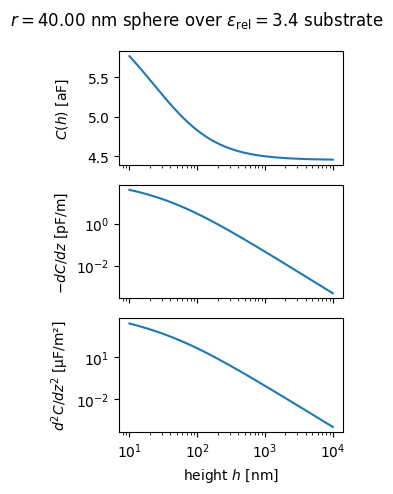

In [19]:
h = ureg.Quantity(np.logspace(1, 4, num=500), "nm")
r = ureg.Quantity(40, "nm")
ureg.default_format = "~P"

Cref = (4 * np.pi * epsilon0 * r).to("aF")

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3.25, 5))
fig.suptitle("$r = ${:0.2f} {:} sphere over $\epsilon_{{\mathrm{{rel}}}} = 3.4$ substrate".format(r.magnitude, r.units))

y = {}
keys = CsphereOverSemiTermSymbolic.keys()

for unit, key in zip(["aF", "pF/m", "uF/(m**2)"], keys):
    y[key] = CsphereOverSemi(key, h, r, epsilon=3.4).to(unit)

axs[0].semilogx(h.magnitude, y[0].magnitude)
axs[1].loglog(h.magnitude, -y[1].magnitude)
axs[2].loglog(h.magnitude, y[2].magnitude)

axs[2].set_xlabel("height $h$ [nm]")
for label, key in zip(["$C(h)$", "$-dC/dz$", "$d^2C/dz^2$"], keys):
    axs[key].set_ylabel(label + " [{:}]".format(y[key].units))

fig.align_ylabels()
plt.tight_layout()

plt.show()

# Integrands

In [20]:
def theta2norm(omega, sample):

    r1 = sample.Ld**2 / (sample.epsilon_s * sample.LD**2)
    r2 = sample.z_r**2 / (sample.epsilon_s * sample.LD**2)
    r3 = sample.z_r**2 / sample.Ld**2
    lambduh = (complex(0,1) * r1 * omega / np.sqrt(omega**2 + r2 + complex(0,1) * r3)).to('').magnitude
     
    khd = (omega * sample.h_d / sample.z_r).to('').magnitude

    r1 = 1/sample.epsilon_d
    t1 = sample.epsilon_eff * np.tanh(khd) + (1 - lambduh) * sample.epsilon_d
    t2 = sample.epsilon_eff + (1 - lambduh) * sample.epsilon_d * np.tanh(khd)

    theta = ((r1 * t1) / t2).magnitude

    return theta

In [21]:
theta2norm(1., sample2)

(0.20629565550969522+0.050682024840946506j)

In [22]:
def theta1norm(omega, sample):

    r1 = sample.Ld**2 / (sample.epsilon_s * sample.LD**2)
    r2 = sample.z_r**2 / (sample.epsilon_s * sample.LD**2)
    r3 = sample.z_r**2 / sample.Ld**2
    lambduh = (complex(0,1) * r1 * omega / np.sqrt(omega**2 + r2 + complex(0,1) * r3)).to('').magnitude
     
    khs = (omega * sample.h_s / sample.z_r).to('').magnitude

    r1 = sample.h_s**2 / sample.z_r**2
    r2 = sample.h_s**2 / (sample.epsilon_s * sample.LD**2)
    r3 = sample.h_s**2 / sample.Ld**2
    etahs = (np.sqrt(r1 * omega**2 + r2 + complex(0,1) * r3)).to('').magnitude

    alpha = (sample.epsilon_eff/sample.epsilon_d).to('').magnitude

    r1 = 1/sample.epsilon_eff
    t1 = - lambduh * np.power(np.tanh(etahs), -1.0)
    t2 = np.tanh(khs) * np.tanh(etahs) + alpha * np.tanh(etahs) - lambduh \
         + 2 * lambduh * mysech(khs) * mysech(etahs) \
         - lambduh**2 * np.tanh(khs) * mysech(etahs) * mycsch(etahs)
    t3 = np.tanh(etahs) - lambduh * np.tanh(khs) + alpha * np.tanh(khs) * np.tanh(etahs)

    theta = (r1 * (t1 + t2 / t3)).magnitude
    
    return theta

In [23]:
theta1norm(1., sample1)

(0.06668086978974141+0.00039578594645346254j)

In [24]:
def integrandC(omega, theta, sample, power):

    ratio = (1 - theta(omega, sample)) / (1 + theta(omega, sample))
    exponent = (2 * sample.cantilever.d / sample.z_r).to('dimensionless').magnitude
    
    return omega**power * np.exp(-1 * omega * exponent) * np.imag(ratio) 

Cast to base units, because each correlation function has its own units.

In [25]:
def C(power, theta, sample):
    
    pre = (-1**(power + 1) * kb * ureg.Quantity(300., 'K')) / \
          (4 * np.pi * epsilon0 * sample.cantilever.omega_c * sample.z_r**(power+1))
    
    integral = integrate.quad(integrandC, 0., np.inf, args=(theta, sample, power))[0]
    
    return (pre * integral).to_base_units()

In [26]:
%%time
integrate.quad(integrandC, 0., np.inf, args=(theta1norm, sample1, 0))[0]

CPU times: user 236 ms, sys: 7.68 ms, total: 244 ms
Wall time: 343 ms


-0.0006710151982600428

In [27]:
%%time
C(0, theta1norm, sample1).to('V^2 s')

CPU times: user 302 ms, sys: 9.83 ms, total: 311 ms
Wall time: 406 ms


4.908100118455968e-13 <Unit('second * volt ** 2')>

Calculate representative values for the other two relevant integrals.  Note that the units depends on the value of the parameter `power`.

In [28]:
C(1, theta1norm, sample1).to('V^2 s/m')

5.783345306502308e-07 <Unit('second * volt ** 2 / meter')>

In [29]:
C(2, theta1norm, sample1).to('V^2 s/m^2')

1.3716940603562473 <Unit('second * volt ** 2 / meter ** 2')>

# Non-contact friction

In [30]:
def gamma_perpendicular(theta, sample):

    prefactor = (sample.cantilever.V_ts**2 / (kb * ureg.Quantity(300., 'K'))).to('V/C')

    c0 = CsphereOverSemi(0, sample.cantilever.d * np.ones(1), sample.cantilever.R, sample.epsilon_d.real.magnitude)        
    c1 = CsphereOverSemi(1, sample.cantilever.d * np.ones(1), sample.cantilever.R, sample.epsilon_d.real.magnitude)
    
    return prefactor * (c1 * c1 * C(0 , theta, sample) + 2 * c0 * c1 * C(1, theta, sample) + c0 * c0 * C(2, theta, sample))

In [31]:
gamma_perpendicular(theta2norm, sample2).to('pN s/m')

Magnitude,[13.923567399718046]
Units,pN s/m


In [32]:
def gamma_parallel(theta, sample):

    prefactor = (sample.cantilever.V_ts**2 / (kb * ureg.Quantity(300., 'K'))).to('V/C')
    c0 = CsphereOverSemi(0, sample.cantilever.d * np.ones(1), sample.cantilever.R, sample.epsilon_d.real.magnitude)

    return prefactor * c0 * c0 * C(2, theta, sample)

In [33]:
gamma_parallel(theta1norm, sample1).to('pN s/m')

Magnitude,[0.2845681228031994]
Units,pN s/m


# Lekkala Figure 9(b)

I cannot find what tip-sample separation $d$ Lekkala assumed in the Figure 9(b) calculation.  Let me assume $d = 300 \: \mathrm{nm}$, the tip-sample separation used for their Figure 7(a) simulation.

In [34]:
cantilever2 = CantileverModel(
    
    f_c = ureg.Quantity(81, 'kHz'),
    V_ts = ureg.Quantity(3, 'V'),
    R = ureg.Quantity(40, 'nm'),
    d = ureg.Quantity(300, 'nm')
)

In [35]:
rho2 = ureg.Quantity(np.logspace(start=19, stop=27, num=40), '1/m^3')

In [36]:
Figure9b = {}

for epsilon_ in [0., 0.005, 0.05, 0.1, 0.50]:

    key = '{:0.3f}'.format(epsilon_)

    result2 = {
        'index': np.arange(len(rho2)),
        'rho': rho2,
        'gamma': ureg.Quantity(np.zeros_like(rho2), 'pN s/m')
    }
    
    for index, rho_ in tqdm(enumerate(rho2)):
    
        sample2 = SampleModel2(
        
            cantilever = cantilever2,
            epsilon_d = ureg.Quantity(complex(3.4, -1 * epsilon_), ''), # <=== updated here
            h_d = ureg.Quantity(69, 'nm'),
            epsilon_s = ureg.Quantity(complex(3.4, -1 * epsilon_), ''), # <=== updated here
            mu = ureg.Quantity(2.7e-10, 'm^2/(V s)'),
            rho = ureg.Quantity(rho_, '1/m^3'),   # <=== updated here
            z_r = ureg.Quantity(100, 'nm')
        )
        
        result2['gamma'][index] = gamma_perpendicular(theta2norm, sample2).to('pN s/m')

    Figure9b[key] = result2

40it [00:10,  3.79it/s]
40it [00:10,  3.66it/s]
40it [00:12,  3.33it/s]
40it [00:11,  3.49it/s]
40it [00:13,  2.89it/s]


In [37]:
sample2

cantilever

      resonance freq = 81.000 kHz
                     = 5.089e+05 rad/s
  tip-sample voltage = 3.0 V
              radius = 80.0 nm
              height = 300.0 nm

dielectric

  epsilon (real) = 3.400
  epsilon (imag) = -0.500
       thickness = 69.0 nm

semiconductor

             epsilon (real) = 3.400
             epsilon (imag) = -0.500
                  thickness = infinite
                   mobility = 2.70e-10 m^2/(V s)
         diffusion constant = 6.98e-12 m^2/s
             charge density = 1.00e+27 m^{-3}
           reference height = 100.0 nm
               Debye length = 0.0 nm
           diffusion length = 3.7 nm
   effective epsilon (real) = 3.400
   effective epsilon (imag) = -9600.264


Screen capture Lekkala2013 Figure 9(b) as **Lekkala2013--Fig9b.png** and extract data points from the png using WebPlotDigitizer ([link](https://apps.automeris.io/wpd/)).

In [38]:
keys = ['0.000','0.005','0.050','0.100', '0.500']

names = ['Lekkala2013--Fig9b--0.000.csv',
         'Lekkala2013--Fig9b--0.005.csv',
         'Lekkala2013--Fig9b--0.050.csv',
         'Lekkala2013--Fig9b--0.100.csv',
         'Lekkala2013--Fig9b--0.500.csv']

Figure9b_original = {}
for key, name in zip(keys, names):
    Figure9b_original[key] = pd.read_csv(name, names=['rho', 'gamma'])

Plot data from the original plot (points) overlayed with my calculation (lines).  My dissipation is somewhat larger than Lekkala's.  Weird!

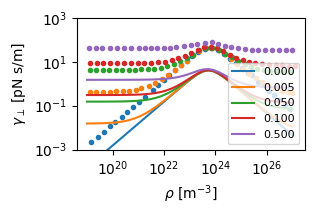

In [39]:
plt.figure(figsize=(3.25, 2.25))

for key, c in zip(Figure9b.keys(), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']):
    
    x1 = Figure9b[key]['rho'].to('1/m^3').magnitude
    y1 = Figure9b[key]['gamma'].to('pN s/m').magnitude

    x2 = Figure9b_original[key]['rho']
    y2 = Figure9b_original[key]['gamma']
        
    plt.loglog(x1, y1, '-', color=c, label=key)
    plt.loglog(x2, y2, '.', color=c)
    
plt.xlabel(r'$\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('$\gamma_{\perp}$ [pN s/m]')
plt.legend(fontsize=8, loc=4)
plt.ylim([1e-3,1e3])
plt.tight_layout()

plt.savefig(THIS + '--Fig-Lekkala2023-Fig-9b.png', dpi=300)
plt.savefig(THIS + '--Fig-Lekkala2023-Fig-9b.pdf')

plt.show()

# Lekkala Figure 7(b)

In [40]:
cantilever1 = CantileverModel(
    
    f_c = ureg.Quantity(81, 'kHz'),
    V_ts = ureg.Quantity(3, 'V'),
    R = ureg.Quantity(80, 'nm'),
    d = ureg.Quantity(300, 'nm')
)

In [41]:
rho1 = ureg.Quantity(np.logspace(start=12, stop=28, num=40), '1/m^3')

In [42]:
Figure7b = {}

for mu_ in [0.15, 4e-7, 2.7e-10, 6e-14]:

    key = '{:0.1e}'.format(mu_)

    result1 = {
        'index': np.arange(len(rho1)),
        'rho': rho1,
        'gamma': ureg.Quantity(np.zeros_like(rho1), 'pN s/m')
    }
    
    for index, rho_ in tqdm(enumerate(rho1)):
    
        sample1 = SampleModel1(

            cantilever = cantilever1,
            h_s = ureg.Quantity(1e6, 'nm'),
            epsilon_s = ureg.Quantity(complex(11.9, -0.05), ''),
            mu = ureg.Quantity(mu_, 'm^2/(V s)'),  # <=== updated here
            rho = ureg.Quantity(rho_, '1/m^3'),   # <=== updated here
            epsilon_d = ureg.Quantity(complex(11.9, -0.05), ''),
            z_r = ureg.Quantity(300, 'nm') # <== SHOULD NOT MATTER
        )
        
        result1['gamma'][index] = gamma_parallel(theta1norm, sample1).to('pN s/m')

    Figure7b[key] = result1

40it [00:08,  4.60it/s]
40it [00:07,  5.17it/s]
40it [00:10,  3.96it/s]
40it [00:08,  4.48it/s]


In [43]:
sample1

cantilever

      resonance freq = 81.000 kHz
                     = 5.089e+05 rad/s
  tip-sample voltage = 3.0 V
              radius = 80.0 nm
              height = 300.0 nm

semiconductor

             epsilon (real) = 11.900
             epsilon (imag) = -0.050
                  thickness = 1000000.0 nm
                   mobility = 6.00e-14 m^2/(V s)
         diffusion constant = 1.55e-15 m^2/s
             charge density = 1.00e+28 m^{-3}
           reference height = 300.0 nm
               Debye length = 0.0 nm
           diffusion length = 0.1 nm
   effective epsilon (real) = 11.900
   effective epsilon (imag) = -21.383

dielectric

  epsilon (real) = 11.900
  epsilon (imag) = -0.050
       thickness = infinite

Screen capture Lekkala2013 Figure 7(b) as **Lekkala2013--Fig7b.png** and extract data points from the png using WebPlotDigitizer ([link](https://apps.automeris.io/wpd/)).

In [44]:
keys = ['1.5e-01','4.0e-07','2.7e-10','6.0e-14']

names = ['Lekkala2013--Fig7b--1.5e-01.csv', 
         'Lekkala2013--Fig7b--4.0e-07.csv',
         'Lekkala2013--Fig7b--2.7e-10.csv',
         'Lekkala2013--Fig7b--6.0e-14.csv']

Figure7b_original = {}
for key, name in zip(keys, names):
    Figure7b_original[key] = pd.read_csv(name, names=['rho', 'gamma'])

Plot data from the original plot (points) overlayed with my calculation (lines).  My dissipation is nearly exactly a factor of 100 larger than Lekkala's.  Weird!

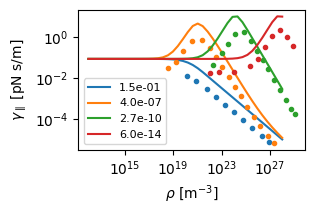

In [45]:
plt.figure(figsize=(3.25, 2.25))

for key, c in zip(Figure7b.keys(), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']):
    
    x1 = Figure7b[key]['rho'].to('1/m^3').magnitude
    y1 = Figure7b[key]['gamma'].to('pN s/m').magnitude
    
    x2 = Figure7b_original[key]['rho']
    y2 = Figure7b_original[key]['gamma']
        
    plt.loglog(x1, y1, '-', color=c, label=key)
    plt.loglog(x2, y2, '.', color=c)
    
plt.xlabel(r'$\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('$\gamma_{\parallel}$ [pN s/m]')
plt.legend(fontsize=8, loc=3)
plt.tight_layout()

plt.savefig(THIS + '--Fig-Lekkala2023-Fig-7b.png', dpi=300)
plt.savefig(THIS + '--Fig-Lekkala2023-Fig-7b.pdf')

plt.show()